# Prospecção de Dados - Data Mining - DI/FCUL2022/2023

## Lab class TP03a

# Decision Trees and ID3

*A Data Mining Tutorial by Andre Falcao (DI/FCUL 2021-2023)*


## A simple implementation of the ID3 algorithm for generating decision trees


The basic algorithm will work recursively as follows
1. For a given data set, identify which variable best subdivides the space through the criterion of minimum entropy
2. Subdivide the space according to the values of the chosen variable creating several subspaces
3. Until a stopping criterion is reached, for each of the subspaces created, return to 1.

As stopping criteria in our implementation we will use the following:
* if a node is pure (all values equal => entropy = 0)
* No more variables to split

The 2nd criterion may imply that the resulting node is not pure, and thus the value assigned to this leaf node will be that of the majority

First we will discretize a sample dataset (here, the iris) for usage is classification

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import numpy as np

data=load_iris()
X=data.data
y=data.target
col_names=data.feature_names

X_iris=np.empty(X.shape,dtype="object")
X_iris[:,:]="Medium"
for i,cname in enumerate(col_names):
    q33, q67=np.quantile(X[:,i], (0.33, 0.67))
    X_iris[X[:,i]<q33, i]="Small"
    X_iris[X[:,i]>q67, i]="Large"

X_train, X_test, y_train, y_test = train_test_split(X_iris, y, test_size=0.33, random_state=0)

To make a decision tree for classification we require a minimum of 3 functions
1. A function that measures the impurity of each node - `entropy`
2. A function that is able to select the feature that minimizes the entropy on each subdivision -  `select_var`
3. A function that goes recursively through the dataset dividing and partitioning the data - `decision_tree`

In [5]:
X_train.shape

(100, 4)

In [2]:
def entropy(y):
    values, counts = np.unique(y,return_counts=True)
    probs=counts/len(y)
    #print(counts, probs)
    return -np.sum(probs*np.log2(probs))

def select_var(X, y):
    N,M = X.shape
    min_ent=1e34
    best_var=-1
    for v in range(M):
        ent=0
        for val in np.unique(X[:,v]):
            srows = X[:,v] == val
            ent+=np.sum(srows)/N*entropy(y[srows])
        if ent<min_ent:
            min_ent=ent
            best_var=v
    return best_var

def decision_tree(X, y, col_names, the_path=[]):
    sv=select_var(X, y)
    N,M=X.shape
    if M==1:
        if len(np.unique(y))==1:
            #pure node
            the_path.append(str(y[0]))
        else:
            #this situation is when the node is not pure!
            #here we will return the most common value
            values, counts = np.unique(y,return_counts=True)
            the_path.append(str(values[counts.argmax()]))
    else:
        X0=np.delete(X, sv, 1)
        cnames=np.delete(col_names,sv)
        for val in np.unique(X[:,sv]):
            srows = X[:,sv]==val
            X_new=X0[srows, :]
            y_new=y[srows]
            the_path.append([(col_names[sv], val)])
            if len(np.unique(y_new))>1:
                decision_tree(X_new, y_new, cnames, the_path[-1] )
            else:
                #pure node - recursive process ends here
                the_path[-1].append(str(y_new[0]))
    return the_path

#### Exercises
1. Identify the recursive component in the `decision_tree` function
2. discuss: what do you perceive as the most intensive process in the algorithm

Let's run our data and check what the output is like:

In [3]:
tree=decision_tree(X_train, y_train, col_names,[])
tree

[[('petal length (cm)', 'Large'),
  [('sepal width (cm)', 'Large'), '2'],
  [('sepal width (cm)', 'Medium'),
   [('sepal length (cm)', 'Large'), '2'],
   [('sepal length (cm)', 'Medium'), '2']],
  [('sepal width (cm)', 'Small'), '2']],
 [('petal length (cm)', 'Medium'),
  [('petal width (cm)', 'Large'),
   [('sepal width (cm)', 'Medium'), '1'],
   [('sepal width (cm)', 'Small'), '2']],
  [('petal width (cm)', 'Medium'), '1']],
 [('petal length (cm)', 'Small'), '0']]

The output is a nested Python list in which the most likely classification result appears in the terminal branches (leaves).

We can get a more sympathetic view of the list by a recursive exploratory process

In [4]:
def show_tree(tree, level=0):
    for branch in tree:
        if type(branch[1])==str and not isinstance(branch, tuple):
            print("\t"*(level), "%s = %s --> %s" % (branch[0][0], branch[0][1], branch[1]))
        elif type(branch[1])==list:
            print("\t"*level,  "%s = %s" % (branch[0][0], branch[0][1]))
            show_tree(branch, level+1)

show_tree(tree)

 petal length (cm) = Large
	 sepal width (cm) = Large --> 2
	 sepal width (cm) = Medium
		 sepal length (cm) = Large --> 2
		 sepal length (cm) = Medium --> 2
	 sepal width (cm) = Small --> 2
 petal length (cm) = Medium
	 petal width (cm) = Large
		 sepal width (cm) = Medium --> 1
		 sepal width (cm) = Small --> 2
	 petal width (cm) = Medium --> 1
 petal length (cm) = Small --> 0


In [5]:
#resolução dpo exercício 3
#mostrar o tennis2


In [6]:
#fazer a árvore e mostrar


## Make predictions

The same tree navigation process can now be applied to new situations. However, since this structure is designed to be interpreted and represented rather than being computationally efficient, an intermediate step will be necessary in which each element is transformed into a dictionary and it is this dictionary that is then used to make the prediction.

In [6]:
def make_prediction(D, tree):
    for branch in tree:
        if type(branch[1])==str and not isinstance(branch, tuple): 
            if D[branch[0][0]]== branch[0][1]: return branch[1]
        elif type(branch[1])==list:
            if D[branch[0][0]]== branch[0][1]: 
                return make_prediction(D, branch)
            
def predict(data, cnames, tree):
    preds=[]
    for elem in data:
        D={col: elem[i] for i, col in enumerate(cnames)}
        preds.append(make_prediction(D, tree))
        
    return preds
                                               

Let's check the results for the first five elements of the testing set

In [7]:
preds=predict(X_test, col_names, tree)

for i in range(5):
    print(X_test[i,:], "-->", preds[i])

['Medium' 'Small' 'Large' 'Large'] --> 2
['Medium' 'Small' 'Medium' 'Medium'] --> 1
['Medium' 'Large' 'Small' 'Small'] --> 0
['Large' 'Medium' 'Large' 'Large'] --> 2
['Small' 'Large' 'Small' 'Small'] --> 0


### Exercise 

1. verify the quality of this classifier with the functions and methods proposed in TP02

In [14]:
from sklearn.metrics import matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
preds = np.array(preds, dtype=int)

MCC = 0.9396863691194209
Accuracy = 0.96


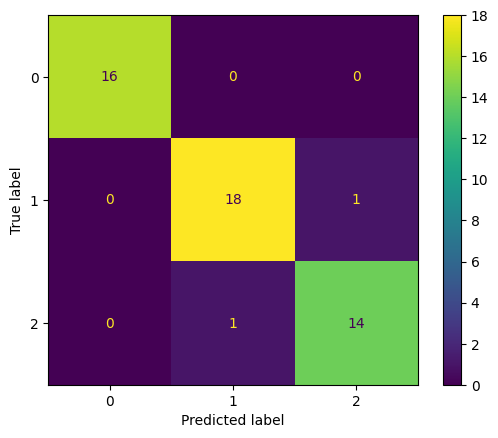

In [15]:
print(f"MCC = {matthews_corrcoef(y_test, preds.astype(int))}")
print(f"Accuracy = {accuracy_score(y_test, preds.astype(int))}")

ConfusionMatrixDisplay(
    confusion_matrix(y_test, preds.astype(int))
).plot()